<a href="https://colab.research.google.com/github/ViktorJOlah/Neuro_ANN/blob/main/multicompartmental%20models/L2_3%20PC/final_L2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#this is for testing purposes, for getting the most out of GPU

import tensorflow as tf
tf.test.gpu_device_name()


# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 


from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
#drive.flush_and_unmount()
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 25.2 GB  | Proc size: 1.2 GB
GPU RAM Free: 15891MB | Used: 389MB | Util   2% | Total 16280MB
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LocallyConnected1D

from keras.models import Sequential
from tensorflow.keras import regularizers



import keras

import tensorflow as tf

import random

import matplotlib.pyplot as plt
import gc

In [ ]:
#define basic parameters for fitting

params = {
    "batch_size": 64,
    "epochs": 1,
    "lr": 0.0010000,
    "time_steps": 128,
    "rec_length": 20000
}


TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()
steps_per_epoch = 2000

In [ ]:
#this is an optional step in case NEURON files contain matrix information. in this case, instead of heaving a continous stream of voltages and inputs, every epoch starts with matrix row an column number, which has to be deleted

with open('/content/drive/My Drive/V1_DNN/Proof_of_principal/L2_3/vmi3.txt') as f:
    lines = f.readlines()

print(len(lines))
counter = 0
for row in lines:
    if row[:3] == '200':
        lines.pop(counter)
    counter += 1

print(len(lines))

f1 = open('/content/drive/My Drive/V1_DNN/Proof_of_principal/L2_3/vmi3_1.txt', "a")
for row in lines:
    f1.write(str(row))
f1.close()

In [ ]:
#load final dataset
data = pd.read_csv('/content/drive/My Drive/V1_DNN/Proof_of_principal/L2_3/vmi3_1.txt', sep=" ", header=None, dtype='float32')

In [ ]:
#cleaning a normalizing dataset 
data.drop([59], axis = 1, inplace=True)
data.columns = [str(data.columns[i]) for i in range(59)]

for place, val in enumerate(data["0"]):
    if val > -20:
        data["0"][place] = -20

#shift votlages to posiive values     
data["0"] = data["0"]+150   #somatic Vm

#normalize everything between 0 and 1
#the reason for printing these values out, is that if a different dataset is loaded, we have to use the original normalization values
print(data["0"].min())
print(data["0"].max())
data["0"] = (data["0"]-data["0"].min())/data["0"].max()
print(data["0"].max())
data["0"] = data["0"]/data["0"].max()

x_all = np.asarray(data, dtype="float32")



48.443
130.0
0.62736154


In [ ]:
data.head

In [ ]:
#reduce dataset for memory conservation
x_all = x_all[:4000000]

In [ ]:
#a basic optional function for selecting traces with high or low firing frequencies
too_much_freq = []
lower_arr = []

for i in range(999):
    spikes = 0
    for k in range(1000):
        if data["0"][i*1001+k] > 0.75 and  data["0"][i*1001+k] > data["0"][i*1001+k-1] and data["0"][i*1001+k] > data["0"][i*1001+k+1]:
            spikes += 1
    print(spikes)
    if spikes > 10:
        too_much_freq.append(1)
    else:
        for k1 in range(1001):
            lower_arr.append(i*1001+k1)

print(f"len_too_much_freq {len(too_much_freq)}")

In [ ]:

del data

#this is a different kind of input dataset creation as the arrays wouldn't fit the memory. We need to create generators which will continously generate datasets for fitting
#tin order to get a clean and random dataset for fitting a validation, we create random vectors for sample selection 


import random

x_all_dim0 = x_all.shape[0]-TIME_STEPS


orig_rand = []
for place, i in enumerate(lower_arr):
    if i%TIME_STEPS > 0.93:
        pass
    else:
        orig_rand.append(i)

x_all_dim0 = x_all.shape[0]-TIME_STEPS-10

rand_x_train = random.sample(range(x_all_dim0), int(x_all_dim0*0.9))
rand_x_test = np.setdiff1d(range(x_all_dim0), rand_x_train)

In [ ]:
#generator for fitting. It requires a random array in order to avoid creating training batches from continous samples
def gen1(df, rand_vec, y_col_index, TIME_STEPS, BATCH_SIZE):
    dim_1 = df.shape[1]
    x = np.zeros((BATCH_SIZE, TIME_STEPS, dim_1))
    y = np.zeros((BATCH_SIZE,1))
    try:
        place = int(len(rand_vec)*random.random())
        randvec = rand_vec[place:place+BATCH_SIZE]
        for i in range(BATCH_SIZE):
            x[i] = df[randvec[i]:TIME_STEPS+randvec[i]]
            y[i] = df[TIME_STEPS+randvec[i], y_col_index:1]
    except:
        for i in range(BATCH_SIZE):
            x[i] = df[:TIME_STEPS]
            y[i] = df[TIME_STEPS, y_col_index:1]

    yield x, y


x_train_counter = tf.data.Dataset.from_generator(gen1, args=[x_all, rand_x_train, 0, TIME_STEPS, BATCH_SIZE], output_types=(tf.float32, tf.float32), output_shapes = ((64,128,59), (64,1)) ).repeat().prefetch(tf.data.experimental.AUTOTUNE)
x_test_counter = tf.data.Dataset.from_generator(gen1, args=[x_all, rand_x_test, 0, TIME_STEPS, BATCH_SIZE], output_types=(tf.float32, tf.float32), output_shapes = ((64,128,59), (64,1)) ).repeat(count=500).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
#CNN-LSTM architecture
def create_model_CNN_LSTM2():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(512, 1, activation='relu', kernel_initializer="he_uniform", padding="causal", kernel_regularizer=regularizers.l1(1e-5), input_shape=(TIME_STEPS, 59)),
        #tf.keras.layers.Conv1D(512, 1, activation='relu', kernel_initializer="he_uniform", padding="causal", input_shape=(TIME_STEPS, 95)),
        tf.keras.layers.Conv1D(256, 5, activation='relu', kernel_initializer="he_uniform", padding="causal"),
        tf.keras.layers.Conv1D(128, 1, activation='tanh', kernel_initializer='glorot_uniform', padding="causal"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.RepeatVector(5),
        tf.keras.layers.LSTM(128, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=True),
        tf.keras.layers.LSTM(128, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=True),
        tf.keras.layers.LSTM(128, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=True),
        tf.keras.layers.Dense(128, activation='relu', kernel_initializer="he_uniform"),
        tf.keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dense(1)])
    model.compile(loss=['mae'], optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001))
    return model

model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

Model not found


In [ ]:
#fitting

is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    model = create_model_CNN_LSTM2()   #change model checkpoint as well!
    model.summary()
    #this code below can be used to load halted fitting results, not just the weights, but the optimizaer state as well
    """
    try:
        tf.keras.models.load_model('/content/drive/My Drive/V1_DNN/Proof_of_principal/SST/act_weights')
        print("model loaded")
    except:
        pass
    """
    #this code below can be used to load halted fitting results, but only weights (if model state is needed as well, fielpath1 shouldn't have an extension, and checkpoint below must have "save_weights_only = False")
    filepath = "act_weights.h5"
    new_model = load_model(f"/content/drive/My Drive/V1_DNN/Proof_of_principal/L6/{filepath}")
    print("model loaded!")


    filepath1 = "weights.{epoch:02d}-{loss:.6f}-minimal1.h5"

    checkpoint = ModelCheckpoint(f"/content/drive/My Drive/V1_DNN/Proof_of_principal/L2_3/{filepath1}", monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    history = new_model.fit(x_train_counter, epochs=5000, steps_per_epoch = 5000, verbose=1, batch_size=64,
                                shuffle=False, validation_data=x_test_counter, validation_steps=400, use_multiprocessing=False, callbacks=[callbacks_list])
 
    
    print("Done with training!")



Building model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 128, 512)          30720     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 128, 256)          655616    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 128, 128)          32896     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 16384)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 128)            8454656   
_________________________________________________________________
lstm_4 (LSTM)                (None, 

# **ANN evaluaion**

In [ ]:
#these functions are just a coy of the ones before
params = {
    "batch_size": 64,
    "epochs": 1,
    "lr": 0.0010000,
    "time_steps": 128,
    "rec_length": 10000
}


TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()
steps_per_epoch = 2000

def serve_CNN_LSTM(x):
    return new_model(x, training=False)


def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")


def trim_dataset(mat,batch_size):

    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

def build_timeseries(mat, y_col_index):

    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,1))
    print("dim_0",dim_0)
    counter = 0
    for i in range(dim_0):
        #get rid of contaminated results (ie: end of trace - beginning of trace samples)
        x[counter] = mat[counter:TIME_STEPS+counter]
        y[counter] = mat[TIME_STEPS+counter, y_col_index:1]
        counter += 1
            
    print("length of time-series i/o",x.shape,y.shape)
    return x[:counter], y[:counter]


In [ ]:
#main function for dataset creation
def create_dataset(data1):

  df_train, df_test = train_test_split(data1, train_size=0.9, test_size=0.1, shuffle=False)
  print(f"Train size is: {len(df_train)}  -- Test size is: {len(df_test)}")



  x_train = np.asarray(df_train, dtype='float32')
  x_test = np.asarray(df_test, dtype='float32')

  x_t, y_t = build_timeseries(x_train, 0)
  
  del x_train
  del df_train


  x_t = trim_dataset(x_t, BATCH_SIZE)
  y_t = trim_dataset(y_t, BATCH_SIZE)
  print("Batch trimmed size",x_t.shape, y_t.shape)

  #this is a must have, otherwise the model thinks that the 3 labels are sequential in time
  y_t = np.reshape(y_t, [y_t.shape[0], 1, 1])

  x_t = np.array(x_t, dtype='float32')
  y_t = np.array(y_t, dtype='float32')

  x_temp, y_temp = build_timeseries(x_test, 0)

  y_temp = np.reshape(y_temp, [y_temp.shape[0], 1, 1])

  x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
  y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

  print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

  x_val = np.array(x_val, dtype='float16')
  y_val = np.array(y_val, dtype='float16')

  del y_temp
  del x_test
  del df_test

  return x_t, y_t, x_val, y_val

In [ ]:
#we need to load an additional dataset for evaluation
data = pd.read_csv('/content/drive/My Drive/V1_DNN/Proof_of_principal/L2_3/vmi3_2.txt', sep=" ", header=None, dtype='float32', nrows=300000)

data.drop([59], axis = 1, inplace=True)
data.columns = [str(data.columns[i]) for i in range(59)]

for place, val in enumerate(data["0"]):
    if val > -20:
        data["0"][place] = -20

data["0"] = data["0"]+150   #somatic Vm

data["0"] = (data["0"]-48.44300079345703)/130.0
data["0"] = data["0"]/0.6273615323580228

#get the size of a 0.74 mV, 0.63 mV, 0.75 mV and 0.23 mV input

print(((80.74-48.44300079345703)/130.0)/0.6273615323580228-((80-48.44300079345703)/130.0)/0.6273615323580228)
print(((80.63-48.44300079345703)/130.0)/0.6273615323580228-((80-48.44300079345703)/130.0)/0.6273615323580228)
print(((80.75-48.44300079345703)/130.0)/0.6273615323580228-((80-48.44300079345703)/130.0)/0.6273615323580228)
print(((80.23-48.44300079345703)/130.0)/0.6273615323580228-((80-48.44300079345703)/130.0)/0.6273615323580228)
x_all = np.asarray(data, dtype="float32")





0.009073408869862243
0.007724658902720505
0.00919602250323881
0.002820113567659932


In [ ]:
x_t, y_t, x_val, y_val = create_dataset(data)

Train size is: 270000  -- Test size is: 30000
dim_0 269872
length of time-series i/o (269872, 128, 59) (269872, 1)
Batch trimmed size (269824, 128, 59) (269824, 1)
dim_0 29872
length of time-series i/o (29872, 128, 59) (29872, 1)
Test size (14912, 128, 59) (14912, 1, 1) (14912, 128, 59) (14912, 1, 1)


In [ ]:
del data

In [ ]:
#loading final ANN
filepath = "weights.67-0.000512-minimal1.h5"

# load the model
new_model = load_model(f"/content/drive/My Drive/V1_DNN/Proof_of_principal/L2_3/{filepath}")


In [ ]:
#checking ANN fit
pred = np.mean(serve_CNN_LSTM(x_t[:10000]), axis=1)

GT = []
for val in x_t[:10001]:
    GT.append(val[-1][0])

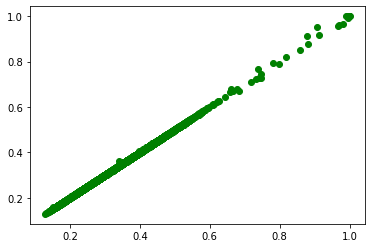

In [ ]:
plt.plot(np.asarray(pred), GT[1:], 'go')

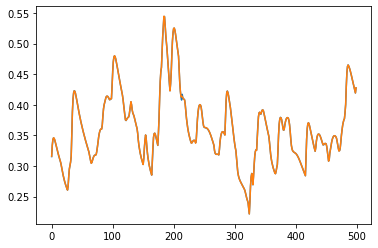

In [ ]:
plt.plot(pred[:500])
plt.plot(GT[1:501])
plt.show()

In [ ]:
#this function runs 50 ANNs on 50 different traces, calculates variance explained, precision and recall, and gives an error value based on spike timing
#as the dataset is non normally distributed, there will be slight biases in the prediction, which can be corrected for
#the argument of this function takes a list of two vlues, which are used to correct predictions linearly (y = mx+b  --> corrected_prediction = arg1[0]*prediction + arg1[1])

from sklearn.metrics import mean_absolute_error
gc.collect()

def go_batch(arg1):
    """
    global GT_spikes
    global res_spikes
    global GT
    global starting_points
    """
    data1 = np.asarray(data, dtype="float32")

    array_count = 50
    starting_points = []
    

    #gather traces with at least a couple of spikes
    for i in range(int(data.shape[0]/1000)-1):
        temp1 = np.sort(np.asarray(data['0'][(i*1000) + 200 :(i*1000) + 1200]))
        if temp1[-5] > 0.8 and (i+1)%10 > 0:
            starting_points.append((i*1000) + 200)
    
    #reduce the number of traces to equal array_count
    starting_points = starting_points[:50]


    #initialize the first starting point, the rest will be added by concatenation
    inputs = np.reshape(data1[starting_points[0]:starting_points[0]+128], [1,128,59])

    MAEs = []
    for i in range(array_count-1):
        inputs = np.concatenate((inputs, np.reshape(data1[starting_points[i+1]:starting_points[i+1]+128], [1,128,59])))


    res = [[] for i in range(array_count)]
    GT = [[] for i in range(array_count)]

    #run the simpulation for 1000 datapoints (500 ms)
    for i in range(1000):
        pred = np.mean(serve_CNN_LSTM(inputs), axis=1)
        for k in range(array_count):
            res[k].append(pred[k][0])
            temp = inputs[k][1:]
            mock_row = data1[starting_points[k]+128+i]
            GT[k].append(mock_row[0])
            mock_row[0] = pred[k][0]* arg1[0] + arg1[1]
            temp = np.concatenate((temp,np.reshape(mock_row, [1,59])))
            inputs[k] = temp
    for i in range(array_count):
        MAEs.append(mean_absolute_error(res[i], GT[i]))
    
    #get var explained
    print(np.asarray(res).shape)
    print(np.asarray(y_t).shape)
    for i in range(50):
        vm_out = np.transpose(res[i])
        vm_GT = np.transpose(np.asarray(y_t[starting_points[i]:starting_points[i]+1000,0,0]))
        #plt.plot(vm_out)
        #plt.plot(vm_GT)
        #plt.show()
        #mse = np.mean((vm_out-vm_GT)**2)
        temp_arr = []
        for k in range(vm_out.shape[0]):
            if vm_out[k] < 0.6 and vm_GT[k] < 0.6:
                temp_arr.append((vm_out[k]-vm_GT[k])**2)
        mse = np.mean(np.asarray(temp_arr))
        #var = np.var(vm_GT)
        temp_GT = list(filter(lambda x: x < 0.6, list(vm_GT)))
        var = np.var(np.asarray(temp_GT))
        var_explained = 1-(mse/var)
        print(var_explained)


    #get spikes from GT and predictions
    GT_spikes = [[] for i in range(array_count)]
    res_spikes = [[] for i in range(array_count)]
    for i in range(array_count):
        ms = 0
        while ms < len(GT[i]):
            if GT[i][ms] > 0.8:
                GT_spikes[i].append(ms)
                ms += 6
            ms += 1
        ms = 0
        while ms < len(res[i]):
            if res[i][ms] > 0.8:
                res_spikes[i].append(ms)
                ms += 6
            ms += 1

    #compare spike timings
    TP = 0
    FN = 0
    FP = 0
    for i in range(array_count):
        TP_temp = 0
        GT_temp = np.sort(GT_spikes[i])
    
        #precision = TP / (TP+FP)
        #recall = TP / (TP+FN)
        if len(res_spikes[i]) == 0:
            FN += len(GT_temp)
        else:
            for item in GT_temp:
                res_temp = [x-item for x in res_spikes[i]]
                res_temp = list(map(abs, res_temp))
                if np.sort(res_temp)[0] < 10:
                    TP_temp += 1
            TP += TP_temp
            FN += (len(GT_temp) - TP_temp)
            FP += (len(res_temp) - TP_temp)
        print(TP_temp,(len(GT_temp) - TP_temp),(len(res_temp) - TP_temp))
            #print(GT_temp, res_spikes[i], TP_temp, (len(GT_temp) - TP_temp), (len(res_temp) - TP_temp))
    #print(TP, FP, FN)

    if TP == 0:
        precision = 0
        recall = 0
        distance = 0
    else:
        precision = TP / (TP+FP)
        recall = TP / (TP+FN)
        distance = abs(precision-recall)

    print(f" {arg1[0]} {arg1[1]} {precision} {recall} {distance} {precision+recall-distance} {3-(precision+recall-distance)}")
    return 3-(precision+recall-distance)

go_batch([0.9999653186890414, 8.220763382875164e-05])


(50, 1000)
(269824, 1, 1)
0.8085910807868639
0.6656371382126185
0.5731066919254775
0.7394539109821108
0.14557768849186292
0.6783047264373904
0.5017443093333573
0.7723531934914205
0.6349789825965368
0.5042742613244504
0.5365027914133877
0.6658362180290344
0.6695142341975556
0.8137341868521789
0.728417063630401
0.7257727306857906
0.7602885670919701
0.8089938272517283
0.7438752024039548
0.37387025480635083
0.7050268323444291
0.7921093373611302
0.7744112215408117
0.5184683900549231
0.5382441288631001
0.870051518496961
0.6470299234905429
0.8134936189417177
0.7626078712427223
0.7035446943625642
0.7802059428342834
0.5323855847692947
0.8992375600983089
0.6430351024946028
0.5934785936253779
0.6477130912432332
0.8684420176156098
0.786687341399214
0.7132055326842675
0.5696786679328709
0.6117732705298672
0.8698786514323411
0.45424870328062716
0.5767386883990686
0.8321360757869832
0.4682392109568153
0.5347699303198463
0.7438690258925069
0.7335561194640303
0.6870210522674158
2 0 0
1 0 0
1 0 0
3 0 0


1.0

In [ ]:
#minimization procedure of spike timing
from scipy.optimize import minimize
x0 = []
x0.append(1.0)
x0.append(0.0)

res = minimize(go_batch, x0, method='nelder-mead', tol=1e-9)

In [ ]:
#to evaluate everything, validation has to be rerun on a different dataset (same as for validation), and go_batch function calculates everything 